## Dataset splitting





Sampling the fraction of the dataset for further model fine-tuning by taking some fraction of the data and separating it in train/validation/test folders each containing examples for both classes, in this case Male and Female images.

Let's start by parsing annotations file and creating the dataframe containing data set annotations. 

| It is implied that you have already downloaded the complete dataset into `data/images` and annotations into `data/annotations` available [here](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)|

In [2]:
# Provide annotations path
path_anno = "annotations/list_attr_celeba.txt"

# Retrive data into a variable
rfile = open(path_anno, 'r')
texts = rfile.read().split("\n")
rfile.close()

In [3]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

columns = np.array(texts[1].split(" "))
columns = columns[columns != ""]
df = []
for txt in texts[2:]:
    txt = np.array(txt.split(" "))
    txt = txt[txt != ""]

    df.append(txt)

# Create a dataframe
df = pd.DataFrame(df)

if df.shape[1] == len(columns) + 1:
    columns = ["image_id"] + list(columns)
df.columns = columns
df = df.dropna()

## cast to integer
for nm in df.columns:
    if nm != "image_id":
        df[nm] = pd.to_numeric(df[nm], downcast="integer")


In [4]:
df

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [5]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

Now we can create separate folders and copy images for training, validation and test:

In [6]:
import glob
import os
import shutil

import pandas as pd


def add_dest_path(df: pd.DataFrame, partition: str) -> pd.DataFrame:
    """
    Add destination path to image dataframe for a given partition
    """
    # Add column with destination path
    df["folder"] = "images/"
    df["path"] = df["folder"] + df["image_id"]

    df["dst_folder"] = f"input/{partition}/"
    df["male_str"] = df.Male.apply(lambda x: "male/" if x == 1 else "female/")
    df["dst_path"] = df["dst_folder"] + df["male_str"] + df["image_id"]
 
    return df


def create_data_folder(df: pd.DataFrame,
                       n_samples_per_class: int,
                       partition: str,
                       seed: int) -> None:
    """Create data folders for train/val/test sets

    Arguments:
      df : Data frame with image annotations
      n_samples_per_class : number of samples per class
      partition : name of the partition
      seed : random seed
    """

    # Sample data
    df_sampled = df.groupby("Male").sample(n=n_samples_per_class,
                                           replace=True,
                                           random_state=seed)

    # Create data folders for sampled data
    fldr_pos, fldr_neg = f"/input/{partition}/male", f"/input/{partition}/female"
    if not os.path.exists(os.getcwd() + fldr_pos):
        os.makedirs(os.getcwd() + fldr_pos)

    if not os.path.exists(os.getcwd() + fldr_neg):
        os.makedirs(os.getcwd() + fldr_neg)

    # Move files to new input folder
    if not glob.glob(fldr_pos):
        for path, dst_path in zip(df_sampled.path.to_list(), df_sampled.dst_path.to_list()):
            shutil.copy(path, dst_path)

This will create three separate folders for each partition, each one containing equal number of images per class:

In [9]:
df = add_dest_path(df, partition="train")
create_data_folder(df, n_samples_per_class=10000, partition="train", seed=13)

df = add_dest_path(df, partition="val")
create_data_folder(df, n_samples_per_class=1250, partition="val", seed=4)

df = add_dest_path(df, partition="test")
create_data_folder(df, n_samples_per_class=4000, partition="test", seed=15)


## Exploratory data analysis

In [7]:
import glob

import pandas as pd

# Get image paths
paths = glob.glob("input/*/*/*.jpg")

d = {"partition": [i.split("/")[1] for i in paths],
     "male": [-1 if i.split("/")[2] == "female" else 1 for i in paths],
     "image_id": [i.split("/")[3] for i in paths],
     "path": paths
     }

# Put all this into one dataframe
eda_df = pd.DataFrame(d)

In [8]:
eda_df

,partition,male,image_id,path
0,train,-1,115579.jpg,input/train/female/115579.jpg
1,train,-1,031166.jpg,input/train/female/031166.jpg
2,train,-1,002757.jpg,input/train/female/002757.jpg
3,train,-1,139504.jpg,input/train/female/139504.jpg
4,train,-1,162634.jpg,input/train/female/162634.jpg
...,...,...,...,...
29358,val,1,062224.jpg,input/val/male/062224.jpg
29359,val,1,007007.jpg,input/val/male/007007.jpg
29360,val,1,162000.jpg,input/val/male/162000.jpg
29361,val,1,021161.jpg,input/val/male/021161.jpg


In [9]:
# Number of images per class
eda_df[eda_df.partition.isin(["train", "val", "test"])].groupby(["male", "partition"], sort=False).count()#.path.plot(kind="pie")

,,image_id,path
male,partition,,
-1,train,9589,9589
1,train,9430,9430
-1,test,3939,3939
1,test,3923,3923
-1,val,1239,1239
1,val,1243,1243


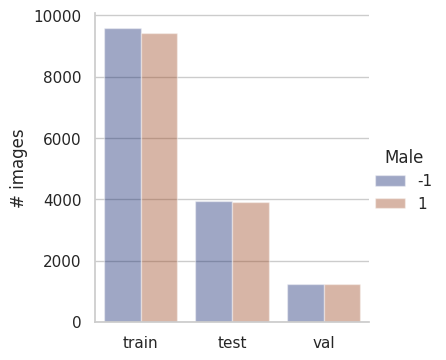

In [10]:
import seaborn as sns

sns.set_theme(style="whitegrid")

# Draw a nested barplot
g = sns.catplot(
    data=eda_df.groupby(["male", "partition"], sort=False).count(), kind="bar",
    x="partition", y="path", hue="male",
    palette="dark", alpha=.4, height=4
)
g.set_axis_labels("", "# images")
g.legend.set_title("Male")
# g.set(yscale="log");


### Dataset image examples

In [22]:
import matplotlib.pyplot as plt


def show_images(images: list) -> None:
    """Display a sequence of images"""

    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Read the image
        img = cv2.imread(images[i], 3)
        # Inverse colors back to rgb
        b, g, r = cv2.split(img)  # get b, g, r
        rgb_img = cv2.merge([r, g, b])
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(rgb_img)

        plt.title("male" if images[i].split("/")[2] == "male" else "female")

        plt.axis('off')

    plt.show(block=True)


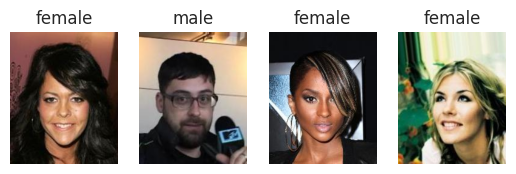

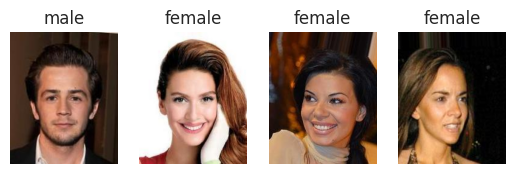

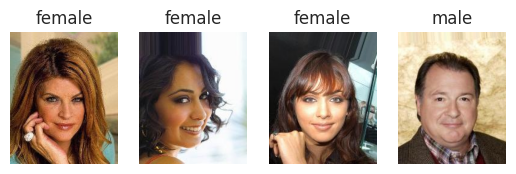

In [23]:
# Visualize some example images
# from training set
for i in range(3):
    show_images(eda_df[eda_df.partition == "train"]['path'].sample(4).tolist())


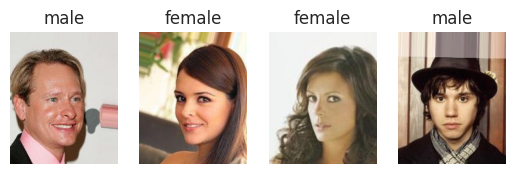

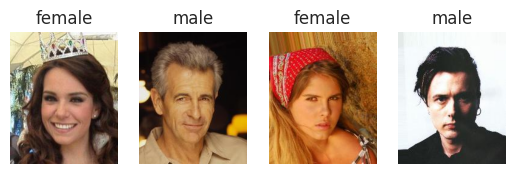

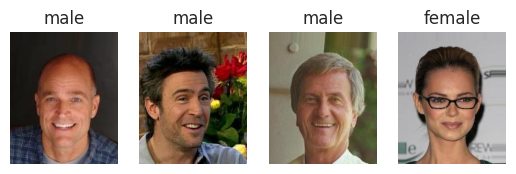

In [24]:
# Visualize some example images
# from validation set
for i in range(3):
    show_images(eda_df[eda_df.partition == "val"]['path'].sample(4).tolist())


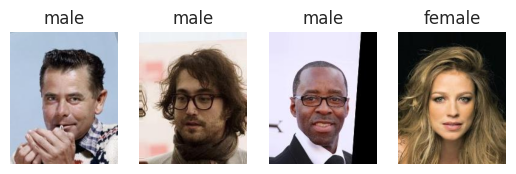

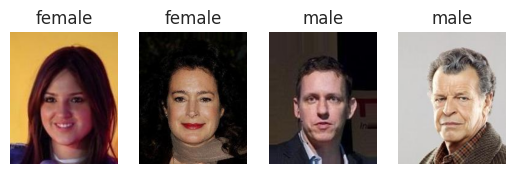

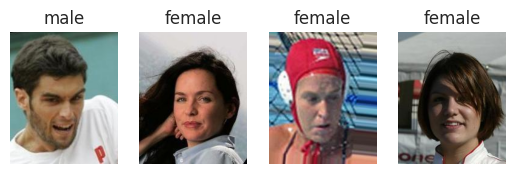

In [25]:
# Visualize some example images
# from test set
for i in range(3):
    show_images(eda_df[eda_df.partition == "test"]['path'].sample(4).tolist())


## Learning curves

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

path = "loss_acc_curves.csv"
df = pd.read_csv(path)

In [12]:
df

,epoch,inception_train_loss,alexnet_train_loss,resnet18_train_loss,accuracy_inception,accuracy_alexnet,accuracy_resnet18
0,1,0.351338,0.524442,0.433337,0.843209,0.744413,0.821021
1,2,0.190565,0.311325,0.198280,0.921079,0.863400,0.919502
2,3,0.152616,0.261820,0.158770,0.937957,0.886009,0.935538
3,4,0.133372,0.233468,0.151225,0.945160,0.898523,0.939061
4,5,0.124137,0.216289,0.131624,0.948788,0.908250,0.946369
5,6,0.117504,0.204341,0.123812,0.950839,0.912246,0.951154
6,7,0.113001,0.200144,0.117996,0.953257,0.913087,0.951102
7,8,0.106897,0.187544,0.114329,0.957989,0.918923,0.952153
8,9,0.100200,0.184025,0.114378,0.959041,0.921500,0.952574
9,10,0.099251,0.172320,0.104565,0.959724,0.923866,0.957674


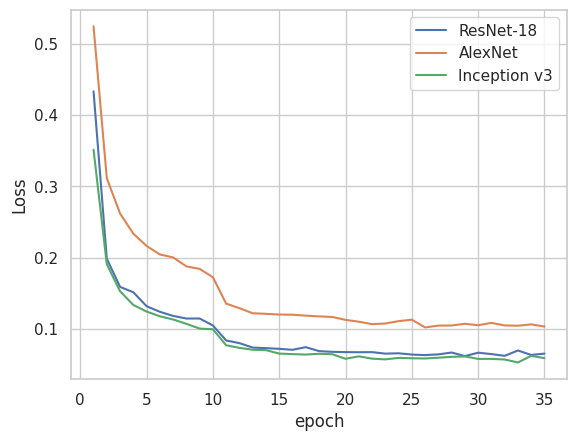

In [13]:
# Plot accuracy
df.plot("epoch", ["resnet18_train_loss", "alexnet_train_loss", "inception_train_loss"])
plt.ylabel("Loss")
plt.legend(["ResNet-18", "AlexNet", "Inception v3"]);

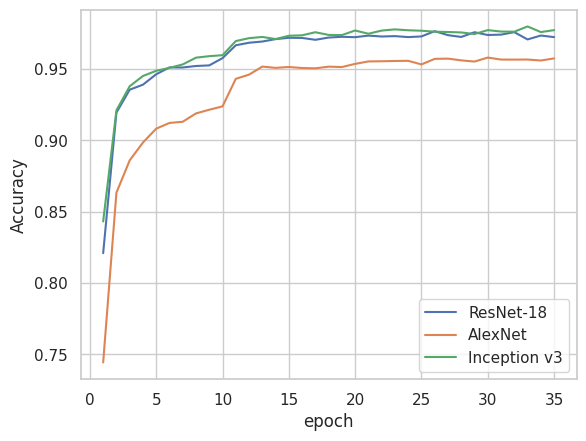

In [14]:
# Plot loss
df.plot("epoch", ["accuracy_resnet18", "accuracy_alexnet", "accuracy_inception"])
plt.ylabel("Accuracy")
plt.legend(["ResNet-18", "AlexNet", "Inception v3"]);